# Stock Price Data and Google Trends with Tiingo and pytrends

## Stock Price Data (Tiingo)

Obtaining stock closing data from 01-00-2021 through 03-31-2021

In [1]:
#first make sure datareader and pytrends are installed (comment this out if it already is):
!pip install pandas-datareader           #remove ! if not using Colab
!pip install pytrends

In [2]:
#import datareader
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd                        
from pytrends.request import TrendReq
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy.stats import f
from statsmodels.tsa.api import ExponentialSmoothing
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#use tiingo api with Elliot's key hardcoded to obtain daily historical price within a range for a given list of equities
s = '2019-01-04'
e = '2021-03-31'
companies = ['AAPL','TSLA','GOOG','MSFT','GME']
five_Ticker_Closing_Prices = pdr.tiingo.TiingoDailyReader(companies,start=s,end=e,api_key="ca7ab3bc66a5c4dff19a6eb8bebcee46c3331411")

In [4]:
#read the stock data from the info in the form of a pandas dataframe
#(because of new years and weekend, trading didnt begin until JANUARY 4th [2021-01-04 00:00:00+00:00])
five_Ticker_Closing_Prices.read()

close      high  ...  divCash  splitFactor
symbol date                                         ...                      
AAPL   2019-01-04 00:00:00+00:00  148.26  148.5500  ...      0.0          1.0
       2019-01-07 00:00:00+00:00  147.93  148.8300  ...      0.0          1.0
       2019-01-08 00:00:00+00:00  150.75  151.8200  ...      0.0          1.0
       2019-01-09 00:00:00+00:00  153.31  154.5300  ...      0.0          1.0
       2019-01-10 00:00:00+00:00  153.80  153.9700  ...      0.0          1.0
...                                  ...       ...  ...      ...          ...
GME    2021-03-25 00:00:00+00:00  183.75  187.5000  ...      0.0          1.0
       2021-03-26 00:00:00+00:00  181.00  218.9344  ...      0.0          1.0
       2021-03-29 00:00:00+00:00  181.30  193.9200  ...      0.0          1.0
       2021-03-30 00:00:00+00:00  194.46  204.3000  ...      0.0          1.0
       2021-03-31 00:00:00+00:00  189.82  199.4600  ...      0.0          1.0

[2820 rows x 12 columns]

In [5]:
#take only closing prices and unpivot
stocks = pd.DataFrame(five_Ticker_Closing_Prices.read()['close']).unstack().T.reset_index()[["date"] + companies]
stocks.head()

symbol,date,AAPL,TSLA,GOOG,MSFT,GME
0,2019-01-04 00:00:00+00:00,148.26,317.69,1070.71,101.93,15.24
1,2019-01-07 00:00:00+00:00,147.93,334.96,1068.39,102.06,15.48
2,2019-01-08 00:00:00+00:00,150.75,335.35,1076.28,102.80,15.81
3,2019-01-09 00:00:00+00:00,153.31,338.53,1074.66,104.27,15.98
4,2019-01-10 00:00:00+00:00,153.80,344.97,1070.33,103.60,15.96


Handling missing data: find missind dates, add them to the dataframe and interpolate

In [6]:
#find missing dates; create a new df
datelist = pd.date_range(pd.to_datetime(s), end=e, tz=stocks.date[0].tz).tolist()
missing_dates = set(datelist) - set(stocks.date)
missing = pd.DataFrame(index=range(len(missing_dates)), columns=companies)
missing['date'] = missing_dates

In [7]:
#insert missing dates
stocks = stocks.append(missing, ignore_index=True).sort_values(by=['date']).reset_index()
del stocks['index']
stocks.head(10)

,date,AAPL,TSLA,GOOG,MSFT,GME
0,2019-01-04 00:00:00+00:00,148.26,317.69,1070.71,101.93,15.24
1,2019-01-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2,2019-01-06 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN
3,2019-01-07 00:00:00+00:00,147.93,334.96,1068.39,102.06,15.48
4,2019-01-08 00:00:00+00:00,150.75,335.35,1076.28,102.80,15.81
5,2019-01-09 00:00:00+00:00,153.31,338.53,1074.66,104.27,15.98
6,2019-01-10 00:00:00+00:00,153.80,344.97,1070.33,103.60,15.96
7,2019-01-11 00:00:00+00:00,152.29,347.26,1057.19,102.80,15.85
8,2019-01-12 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN
9,2019-01-13 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN


In [8]:
#interpolate with standard linear settings
[stocks[col].interpolate(inplace=True) for col in companies]
stocks.head(10)

,date,AAPL,TSLA,GOOG,MSFT,GME
0,2019-01-04 00:00:00+00:00,148.260000,317.690000,1070.710000,101.930000,15.24
1,2019-01-05 00:00:00+00:00,148.150000,323.446667,1069.936667,101.973333,15.32
2,2019-01-06 00:00:00+00:00,148.040000,329.203333,1069.163333,102.016667,15.40
3,2019-01-07 00:00:00+00:00,147.930000,334.960000,1068.390000,102.060000,15.48
4,2019-01-08 00:00:00+00:00,150.750000,335.350000,1076.280000,102.800000,15.81
5,2019-01-09 00:00:00+00:00,153.310000,338.530000,1074.660000,104.270000,15.98
6,2019-01-10 00:00:00+00:00,153.800000,344.970000,1070.330000,103.600000,15.96
7,2019-01-11 00:00:00+00:00,152.290000,347.260000,1057.190000,102.800000,15.85
8,2019-01-12 00:00:00+00:00,151.526667,342.973333,1053.023333,102.550000,15.78
9,2019-01-13 00:00:00+00:00,150.763333,338.686667,1048.856667,102.300000,15.71


# Get Data from Google Trends
Install pytrends (if needed) and import packages. 
Select pytrends to be searched based on American English, and a timezone of 300 (which is US-EST). Use https://forbrains.co.uk/international_tools/earth_timezones to change timezone, but drop the "-" sign. For example, if EST is "-300", make it "300". More info on this link: https://stackoverflow.com/questions/51337898/get-another-timezone-in-pytrend-api-offset

In [9]:
pytrend = TrendReq(hl='en-US', tz=300)

In [10]:
dataset = []

for x in range(0,len(companies)):
     keywords = [companies[x]]
     pytrend.build_payload(
     kw_list=keywords,
     cat=0, 
     timeframe=s+" "+e,
     geo='US')
     data = pytrend.interest_over_time()
     if not data.empty:
          data = data.drop(labels=['isPartial'],axis='columns')
          dataset.append(data)

dataset = pd.concat(dataset, axis=1)

In [11]:
dataset.head()

,AAPL,TSLA,GOOG,MSFT,GME
date,,,,,
2019-01-06,30,9,64,23,0
2019-01-13,23,11,64,22,0
2019-01-20,18,12,56,15,0
2019-01-27,46,16,72,40,0
2019-02-03,26,10,92,19,0


##Forecasting models

###Train/Test split

In [12]:
test_size = 0.1
split_idx = int(np.floor((1-test_size)*len(stocks)))
stocks_train = stocks.iloc[:split_idx,:]
stocks_test = stocks.iloc[split_idx:,:]

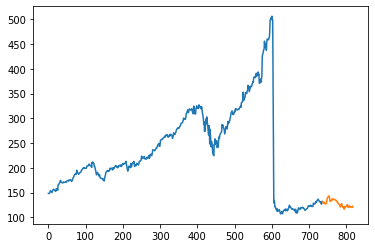

In [13]:
plt.plot(stocks_train.iloc[:,1])
plt.plot(stocks_test.iloc[:,1])

###Linear Regression

In [14]:
#set max power and create list of predictors
p = 4
t_trRng = np.array(range(len(stocks_train)))
t_testRng = np.array(range(len(stocks_train), len(stocks)))
t_train = np.array([t_trRng**i for i in range(p)]).T
t_test = np.array([t_testRng**i for i in range(p)]).T

Fit a regression line using OLS from statsmodels. Testing significance with F-test.

In [19]:
fit_lr = []
yhat_lr = []
for i in range(len(companies)):
    y = stocks_train.iloc[:, i+1]
    y_mean = np.mean(y)
    lr_fin = sm.OLS(y, t_train[:,:2]).fit()
    x1a = t_train[:,:2]
    x1a_t = t_test[:,:2]
    for j in range(2, p):
        lr0 = lr_fin
        x0 = x1a
        t0 = x1a_t
        y_pr0 = lr0.predict(x0)
        ypr0_t = lr0.predict(t0)
        ssr0 = sum((y_pr0 - y_mean)**2)
        x1a = t_train[:, :j+1]
        x1a_t = t_test[:, :j+1]
        lr1 = sm.OLS(y, x1a).fit()
        y_pr1 = lr1.predict(x1a)
        ypr1_t = lr1.predict(x1a_t)
        ssr1 = sum((y_pr1 - y_mean)**2)
        ssr_new = ssr1 - ssr0
        mse1 = sum((y - y_pr1)**2)/(len(y) + j - 2)
        if ssr_new/mse1 <= f.ppf(0.05, 1, (len(y) + j - 2)):
            y_pr = y_pr0
            #x_fin = x0
            yh = ypr0_t
            break
        y_pr = y_pr1
        yh = ypr1_t
        #x_fin = x1a
        lr_fin = lr1  
    fit_lr.append(y_pr)
    yhat_lr.append(yh)

In [24]:
np.sqrt(mean_squared_error(stocks_train.iloc[:,1], fit_lr[0]))

58.688051382603454

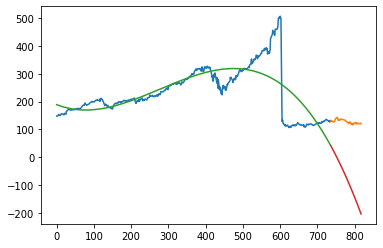

In [25]:
plt.plot(stocks_train.iloc[:,1])
plt.plot(stocks_test.iloc[:,1])
plt.plot(fit_lr[0])
plt.plot(t_testRng, yhat_lr[0])

###Exponential Smoothing

In [53]:
yhat_hw = []
for i in range(len(companies)):
    fit1 = ExponentialSmoothing(np.asarray(stocks_train.iloc[:, i+1]), seasonal_periods=7, trend='add', seasonal='mul').fit()
    yhat_hw.append(fit1.forecast(len(t_testRng)))

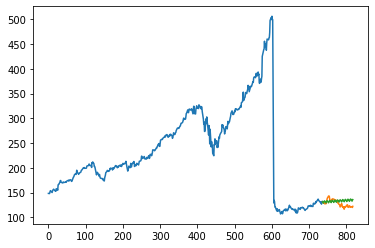

In [58]:
plt.plot(stocks_train.iloc[:, 1])
plt.plot(stocks_test.iloc[:, 1])
plt.plot(t_testRng, yhat_hw[0])